In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

In [10]:
# Load the dataset
file_path = "C:/Users/nihar/OneDrive/Desktop/Bootcamp/SCMA 632/DataSet/APSE Historical Data.csv"
data = pd.read_csv(file_path)

In [12]:
# Convert Date column to datetime type
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')

In [14]:
# Ensure the data is sorted by date
data = data.sort_values(by='Date')

In [16]:
# Ensure that the Price column is numeric
data['Price'] = data['Price'].str.replace(',', '').astype(float)

# Convert other relevant columns to numeric after removing non-numeric characters
data['Open'] = data['Open'].str.replace(',', '').astype(float)
data['High'] = data['High'].str.replace(',', '').astype(float)
data['Low'] = data['Low'].str.replace(',', '').astype(float)

In [18]:
# Clean and convert Vol. column
def clean_volume(vol):
    if isinstance(vol, str):
        if 'M' in vol:
            return float(vol.replace('M', '')) * 1e6
        elif 'K' in vol:
            return float(vol.replace('K', '')) * 1e3
        else:
            return np.nan
    return vol

data['Vol.'] = data['Vol.'].apply(clean_volume)
data['Vol.'].fillna(data['Vol.'].median(), inplace=True)

In [20]:
# Convert Change % column
data['Change %'] = data['Change %'].str.replace('%', '').astype(float)

In [22]:
# Check for missing values
print("Missing values before filling:")
print(data.isna().sum())

Missing values before filling:
Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


In [24]:
# Identify outliers using IQR method for the Price column
Q1 = data['Price'].quantile(0.25)
Q3 = data['Price'].quantile(0.75)
IQR = Q3 - Q1
outliers = data[(data['Price'] < (Q1 - 1.5 * IQR)) | (data['Price'] > (Q3 + 1.5 * IQR))]

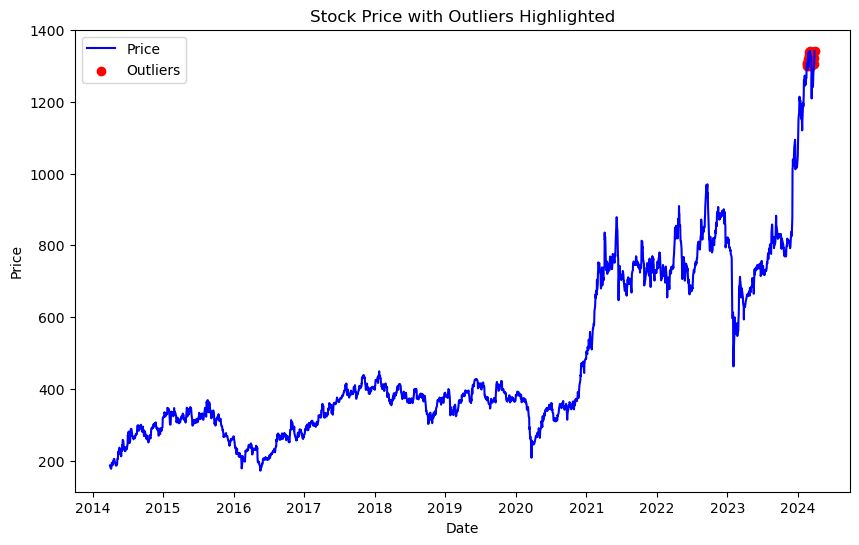

In [26]:
# Plot outliers
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Price'], label='Price', color='blue')
plt.scatter(outliers['Date'], outliers['Price'], color='red', label='Outliers')
plt.title('Stock Price with Outliers Highlighted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

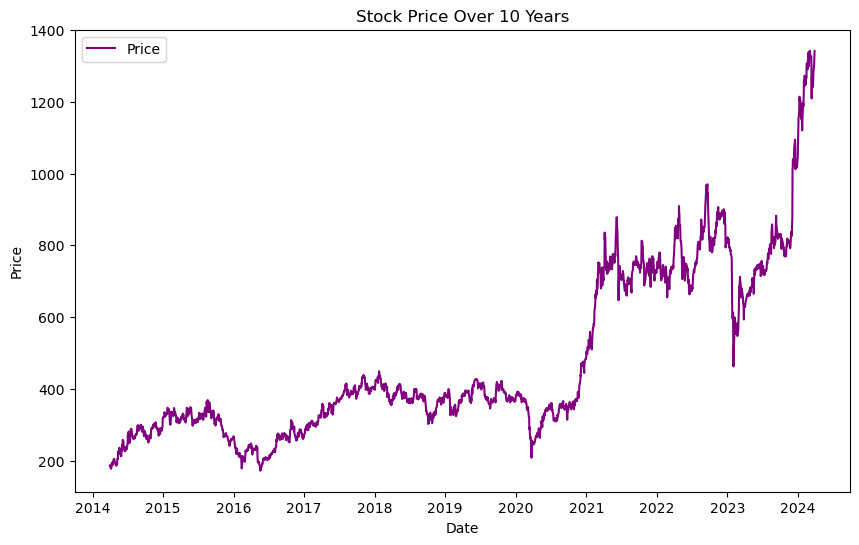

In [28]:
# Plot a line graph for the price of all ten years
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Price'], label='Price', color='purple')
plt.title('Stock Price Over 10 Years')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

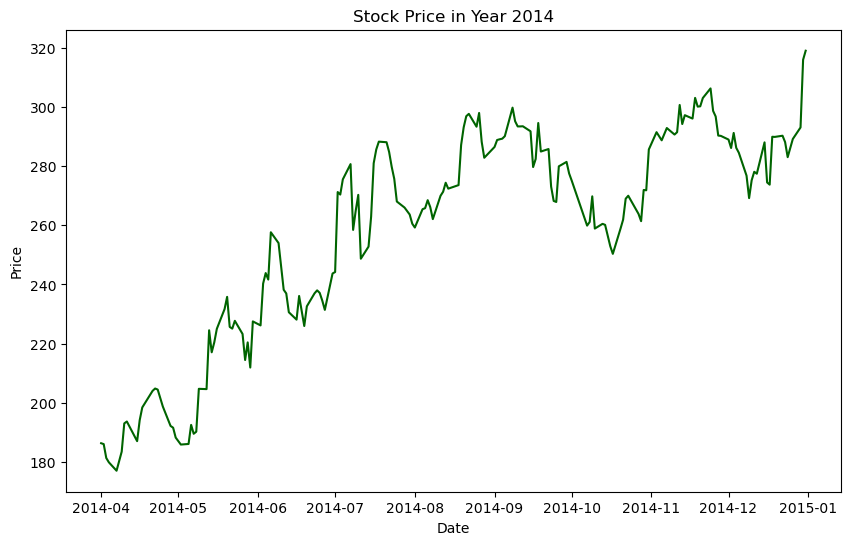

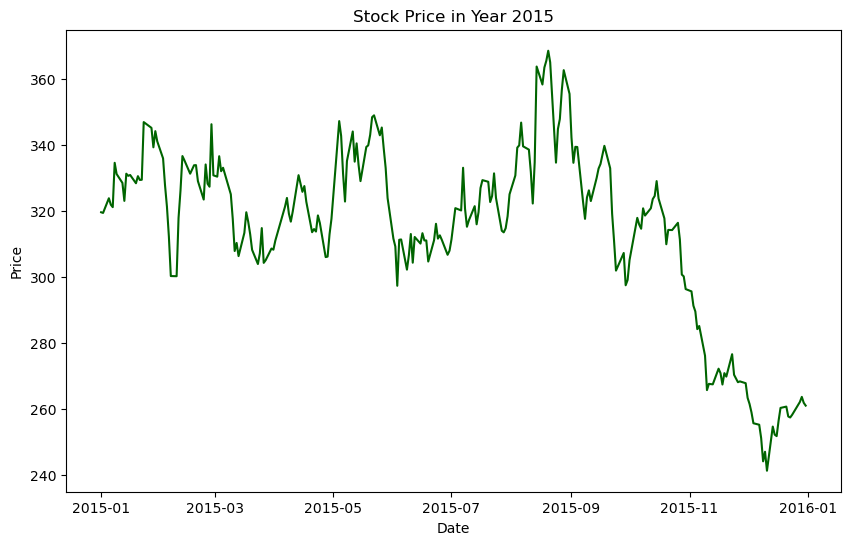

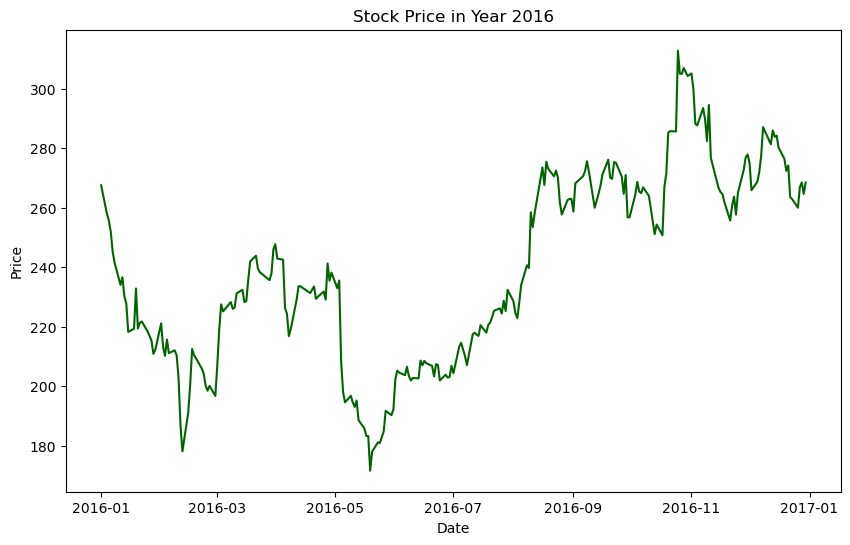

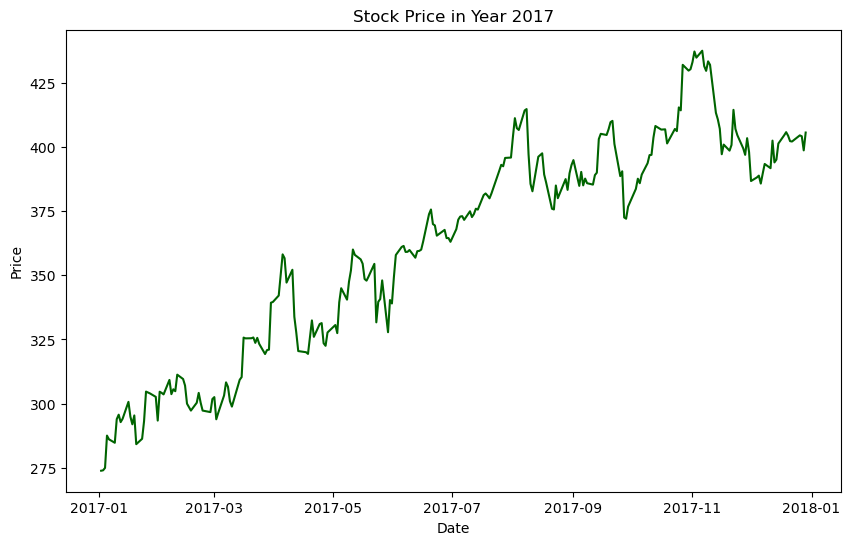

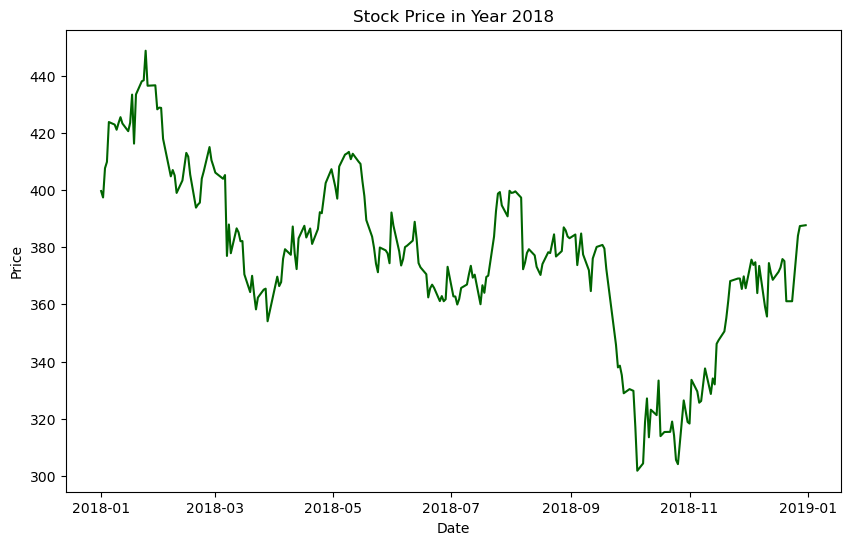

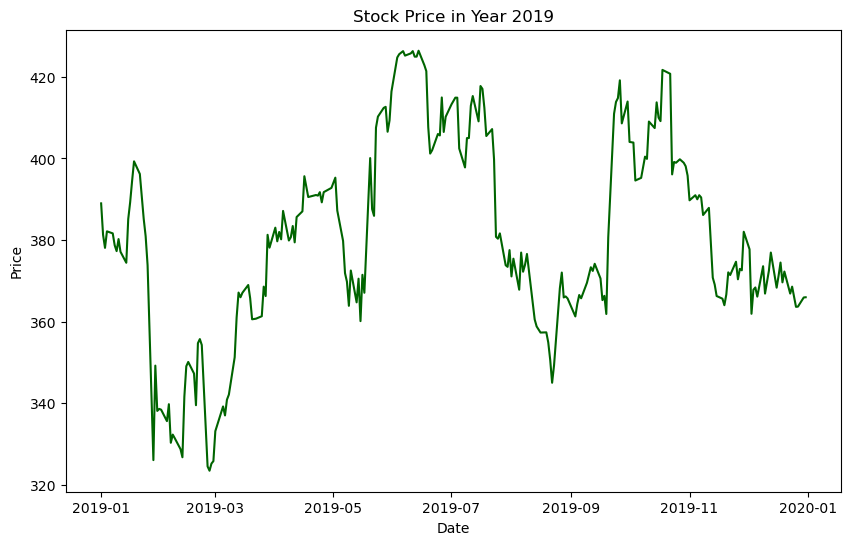

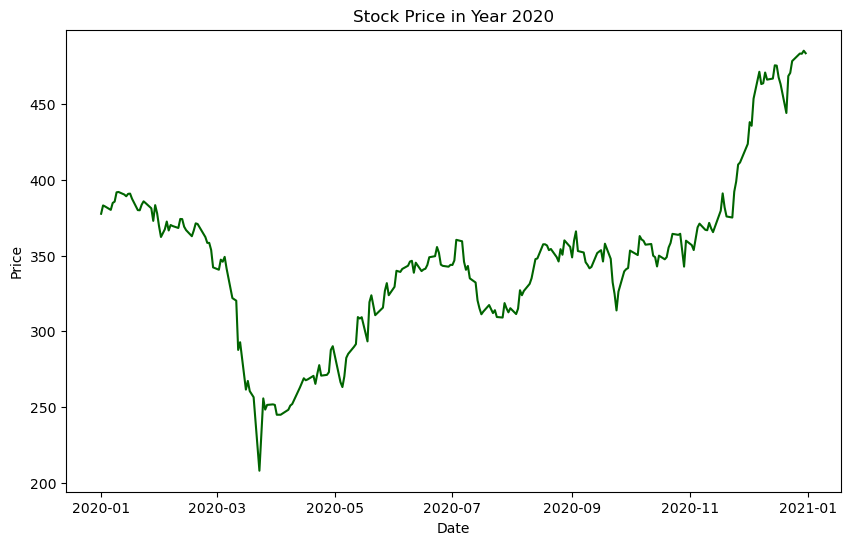

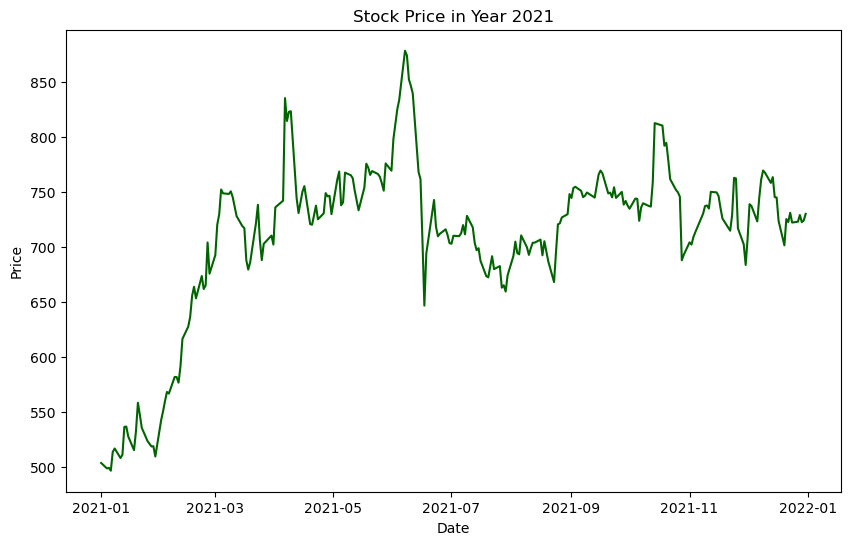

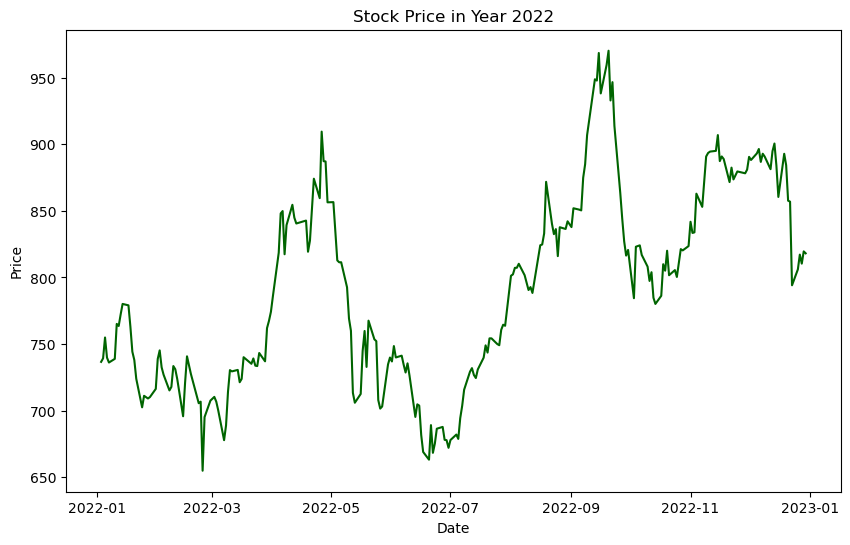

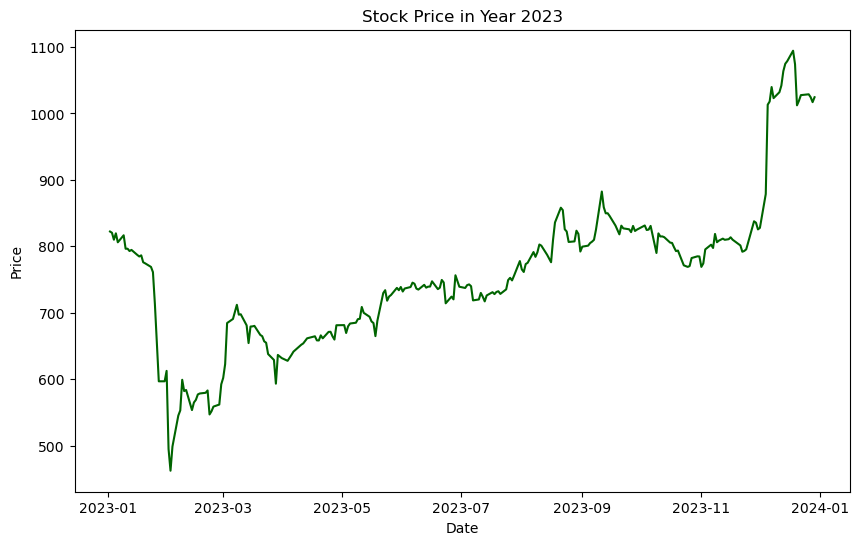

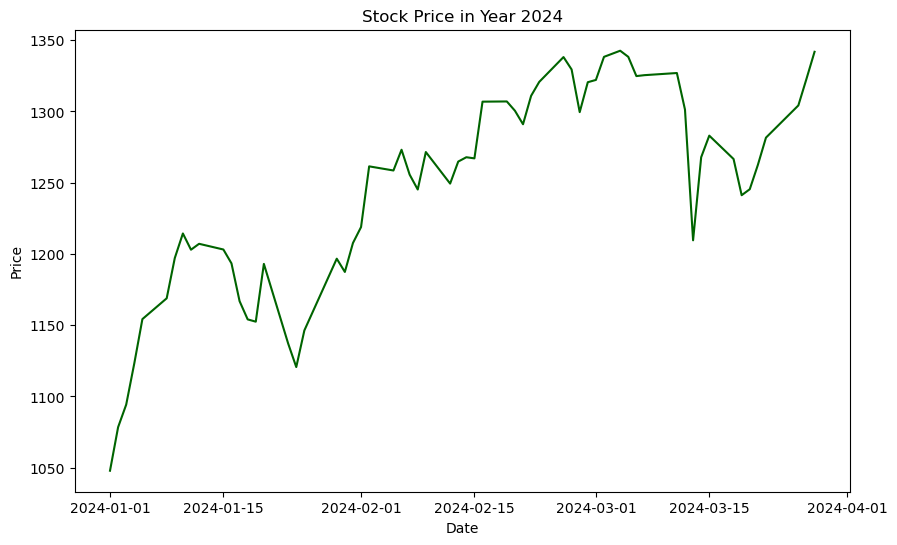

In [36]:
# Create and store individual year plots in a list
data['Year'] = data['Date'].dt.year
years = data['Year'].unique()

for year in years:
    yearly_data = data[data['Year'] == year]
    plt.figure(figsize=(10, 6))
    plt.plot(yearly_data['Date'], yearly_data['Price'], color='darkgreen')
    plt.title(f'Stock Price in Year {year}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

In [38]:
# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

In [40]:
# Check the structure of the train and test datasets
print("Train Data Structure:")
print(train_data.info())
print("Test Data Structure:")
print(test_data.info())

Train Data Structure:
<class 'pandas.core.frame.DataFrame'>
Index: 1729 entries, 279 to 1609
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1729 non-null   datetime64[ns]
 1   Price     1729 non-null   float64       
 2   Open      1729 non-null   float64       
 3   High      1729 non-null   float64       
 4   Low       1729 non-null   float64       
 5   Vol.      1729 non-null   float64       
 6   Change %  1729 non-null   float64       
 7   Year      1729 non-null   int32         
dtypes: datetime64[ns](1), float64(6), int32(1)
memory usage: 114.8 KB
None
Test Data Structure:
<class 'pandas.core.frame.DataFrame'>
Index: 741 entries, 1411 to 752
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      741 non-null    datetime64[ns]
 1   Price     741 non-null    float64       
 2   Open      741 non-null    f

In [42]:
# Aggregate the data to monthly frequency
data['Month'] = data['Date'].dt.to_period('M')
monthly_data = data.groupby('Month').agg({
    'Price': 'mean',
    'Open': 'mean',
    'High': 'mean',
    'Low': 'mean',
    'Vol.': 'sum',
    'Change %': 'mean'
}).reset_index()

In [44]:
# Check for missing values in monthly data
print("Missing values in monthly data before filling:")
print(monthly_data.isna().sum())

Missing values in monthly data before filling:
Month       0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


In [46]:
# Fill missing values in monthly data explicitly
monthly_data['Price'] = monthly_data['Price'].interpolate(method='linear').ffill().bfill()

In [48]:
# Check for missing values again
print("Missing values in monthly data after filling:")
print(monthly_data.isna().sum())

Missing values in monthly data after filling:
Month       0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


In [50]:
# Reindex to ensure all months are covered in the range
monthly_data.set_index('Month', inplace=True)
monthly_data = monthly_data.reindex(pd.period_range(start=monthly_data.index.min(), end=monthly_data.index.max(), freq='M'))

In [52]:
# Fill any remaining missing values after reindexing
monthly_data = monthly_data.ffill().bfill()

In [54]:
# Convert to time series object and set frequency
ts_monthly = monthly_data['Price']
ts_monthly.index = ts_monthly.index.to_timestamp()

In [56]:
# Double-check for any remaining missing values
print("Missing values after converting to time series:")
print(ts_monthly.isna().sum())

Missing values after converting to time series:
0


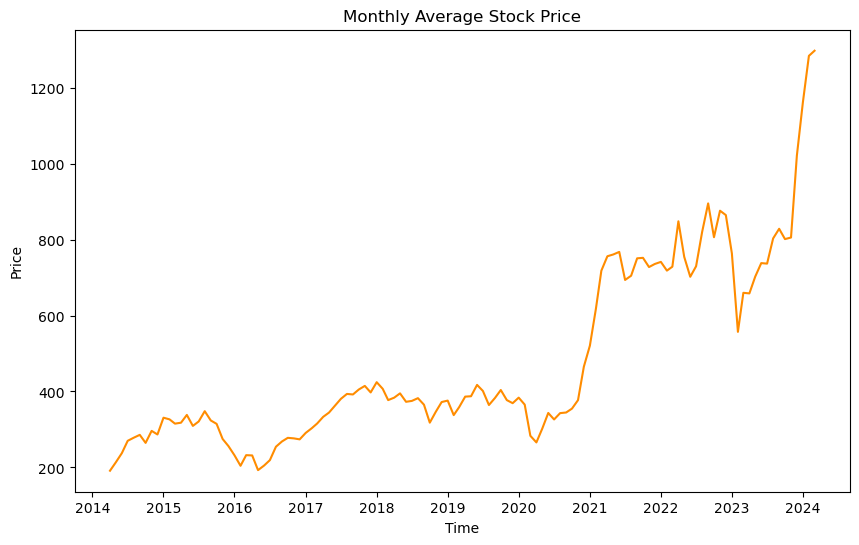

In [58]:
# Plot the monthly time series
plt.figure(figsize=(10, 6))
plt.plot(ts_monthly, color='darkorange')
plt.title('Monthly Average Stock Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

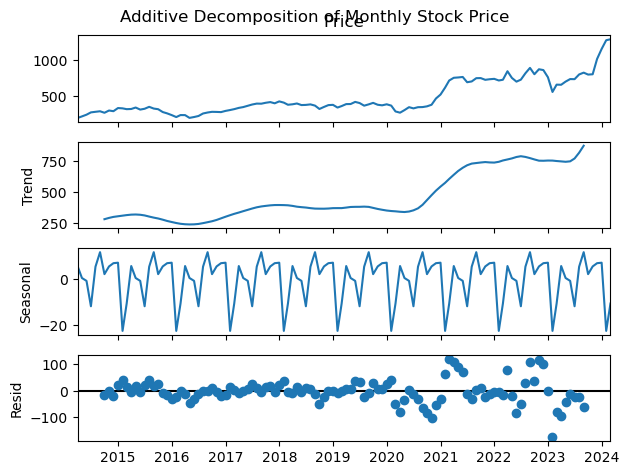

In [60]:
# Decompose the time series using additive model
try:
    decomposed_additive = seasonal_decompose(ts_monthly, model='additive', period=12)
    # Plot the additive decomposition
    decomposed_additive.plot()
    plt.suptitle('Additive Decomposition of Monthly Stock Price')
    plt.show()
except ValueError as e:
    print("Error in additive decomposition:", e)

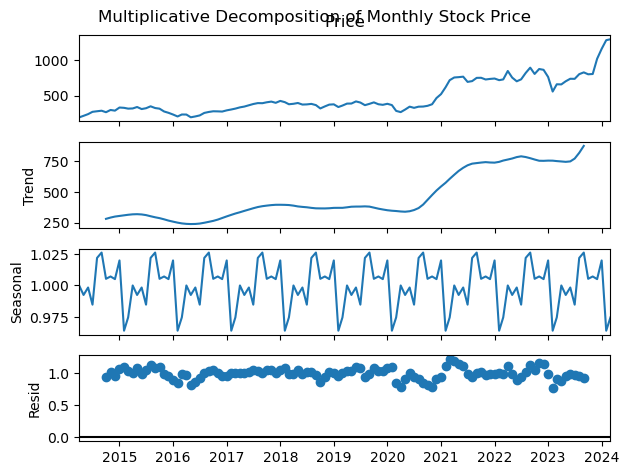

In [62]:
# Decompose the time series using multiplicative model
try:
    decomposed_multiplicative = seasonal_decompose(ts_monthly, model='multiplicative', period=12)
    # Plot the multiplicative decomposition
    decomposed_multiplicative.plot()
    plt.suptitle('Multiplicative Decomposition of Monthly Stock Price')
    plt.show()
except ValueError as e:
    print("Error in multiplicative decomposition:", e)

In [64]:
# Fit Holt-Winters model to the monthly data
hw_model_monthly = ExponentialSmoothing(ts_monthly, trend='add', seasonal='add', seasonal_periods=12).fit()

In [66]:
# Forecast for the next 12 months (1 year)
hw_forecast_1 = hw_model_monthly.forecast(steps=12)

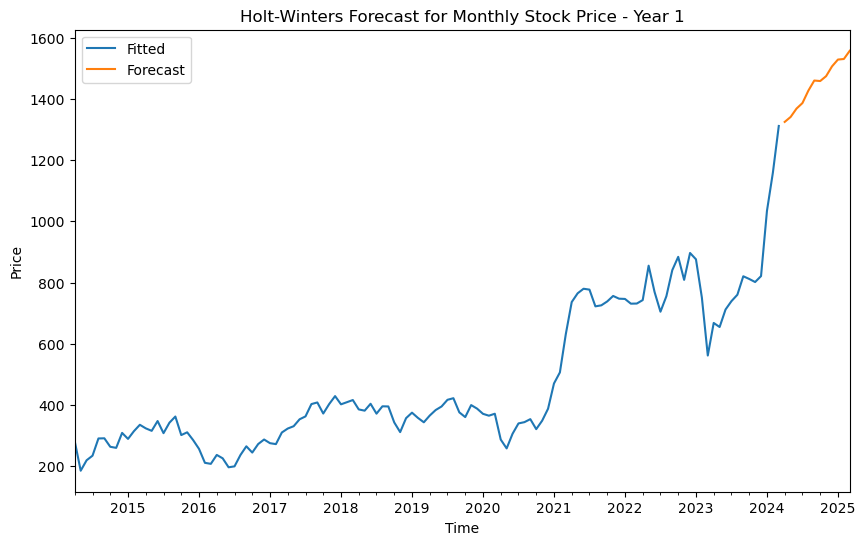

In [68]:
# Plot the forecast for the first year
plt.figure(figsize=(10, 6))
hw_model_monthly.fittedvalues.plot(label='Fitted')
hw_forecast_1.plot(label='Forecast')
plt.title('Holt-Winters Forecast for Monthly Stock Price - Year 1')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [70]:
# Update the model with the new data and forecast for the next 12 months (second year)
extended_ts_monthly = pd.concat([ts_monthly, hw_forecast_1])
hw_model_monthly_2 = ExponentialSmoothing(extended_ts_monthly, trend='add', seasonal='add', seasonal_periods=12).fit()
hw_forecast_2 = hw_model_monthly_2.forecast(steps=12)

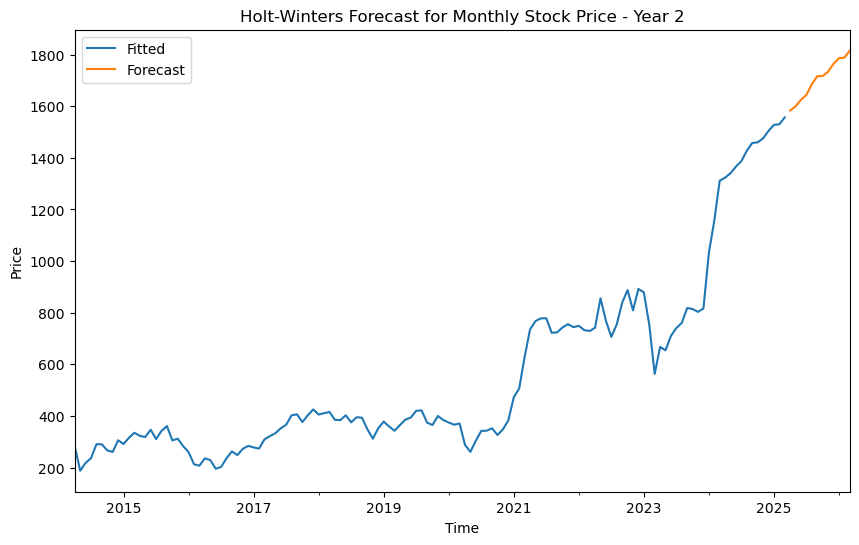

In [72]:
# Plot the forecast for the second year
plt.figure(figsize=(10, 6))
hw_model_monthly_2.fittedvalues.plot(label='Fitted')
hw_forecast_2.plot(label='Forecast')
plt.title('Holt-Winters Forecast for Monthly Stock Price - Year 2')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [74]:
# Update the model with the new data and forecast for the next 12 months (third year)
extended_ts_monthly_2 = pd.concat([extended_ts_monthly, hw_forecast_2])
hw_model_monthly_3 = ExponentialSmoothing(extended_ts_monthly_2, trend='add', seasonal='add', seasonal_periods=12).fit()
hw_forecast_3 = hw_model_monthly_3.forecast(steps=12)

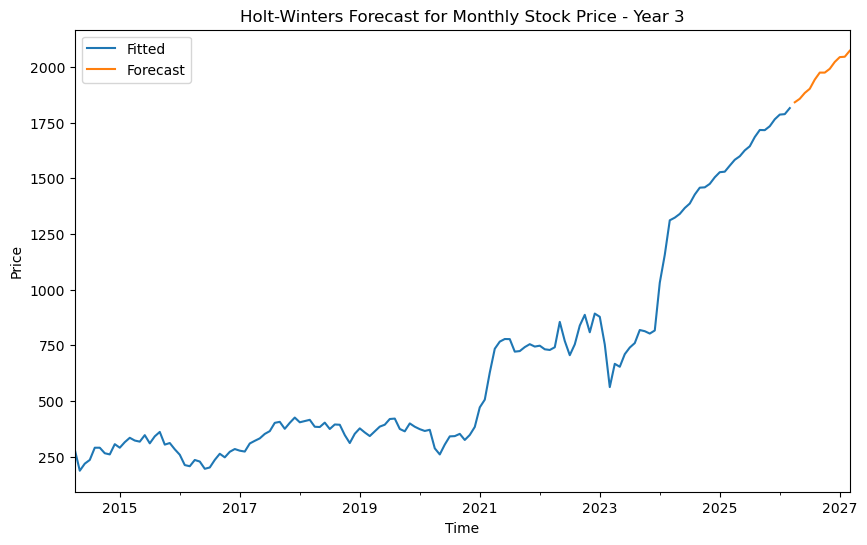

In [76]:
# Plot the forecast for the third year
plt.figure(figsize=(10, 6))
hw_model_monthly_3.fittedvalues.plot(label='Fitted')
hw_forecast_3.plot(label='Forecast')
plt.title('Holt-Winters Forecast for Monthly Stock Price - Year 3')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [78]:
# Fit ARIMA model to the daily data and perform diagnostic checks
ts_daily = pd.Series(data['Price'].values, index=data['Date'])

In [80]:
# Fit an ARIMA model to the daily data
arima_model_daily = ARIMA(ts_daily, order=(5,1,0)).fit()

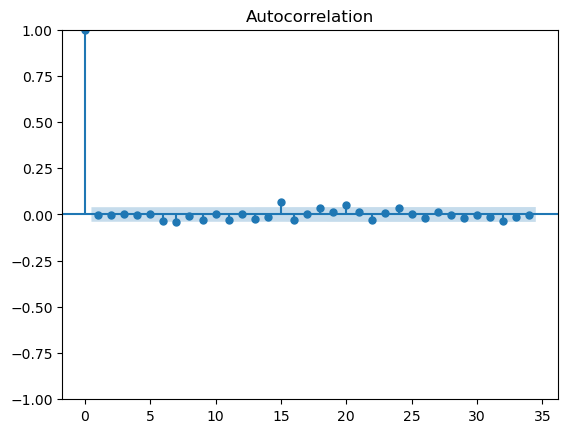

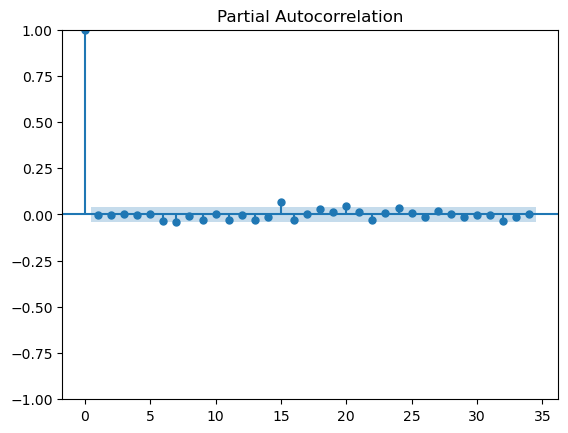

In [82]:
# Perform diagnostic checks on the ARIMA model
sm.graphics.tsa.plot_acf(arima_model_daily.resid)
sm.graphics.tsa.plot_pacf(arima_model_daily.resid)
plt.show()

In [84]:
# Check if a Seasonal-ARIMA (SARIMA) fits better
sarima_model_daily = SARIMAX(ts_daily, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()

In [85]:
# Compare AIC values of ARIMA and SARIMA models
print("AIC of ARIMA model:", arima_model_daily.aic)
print("AIC of SARIMA model:", sarima_model_daily.aic)

AIC of ARIMA model: 19515.19192769427
AIC of SARIMA model: 19476.48425020223


In [89]:
# Forecast the series for the next three months (90 days)
forecast_sarima = sarima_model_daily.get_forecast(steps=90)
forecast_index = pd.date_range(start=ts_daily.index[-1], periods=90, freq='D')

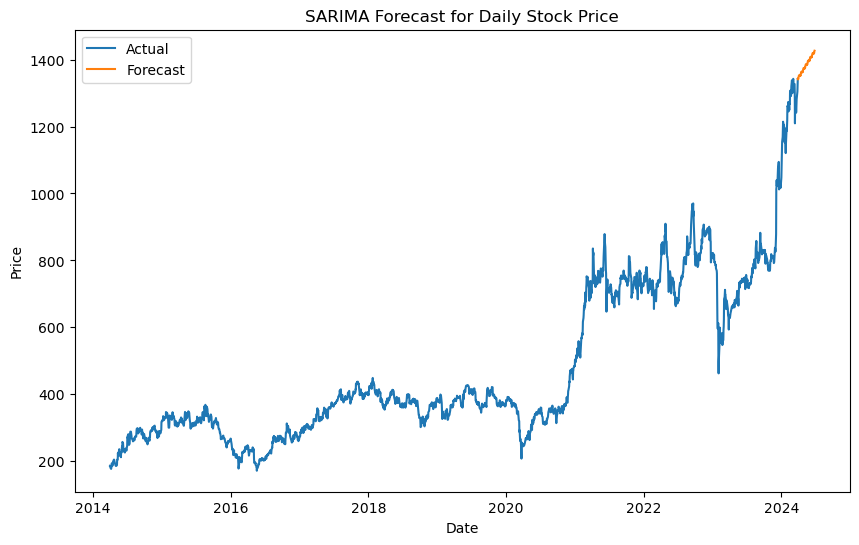

In [91]:
# Plot the SARIMA forecast
plt.figure(figsize=(10, 6))
plt.plot(ts_daily, label='Actual')
plt.plot(forecast_index, forecast_sarima.predicted_mean, label='Forecast')
plt.title('SARIMA Forecast for Daily Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [111]:
# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=123)

In [113]:
# Normalize the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']])
test_scaled = scaler.transform(test_data[['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']])

In [115]:
# Prepare training and testing datasets for ML models
X_train = train_scaled[:, 1:]
y_train = train_scaled[:, 0]
X_test = test_scaled[:, 1:]
y_test = test_scaled[:, 0]

In [117]:
# Decision Tree model
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

In [119]:
# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=123)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [121]:
# Rescale predictions
y_pred_dt_rescaled = scaler.inverse_transform(np.concatenate((y_pred_dt.reshape(-1, 1), X_test), axis=1))[:, 0]
y_pred_rf_rescaled = scaler.inverse_transform(np.concatenate((y_pred_rf.reshape(-1, 1), X_test), axis=1))[:, 0]

In [123]:
# Evaluate the models
print("Decision Tree Model")
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_dt_rescaled))
print("R-squared:", r2_score(y_test, y_pred_dt_rescaled))

Decision Tree Model
MAPE: 2479.5974186501635
R-squared: -6645337.773931585


In [125]:
print("Random Forest Model")
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_rf_rescaled))
print("R-squared:", r2_score(y_test, y_pred_rf_rescaled))

Random Forest Model
MAPE: 2477.174989543676
R-squared: -6641299.021023003


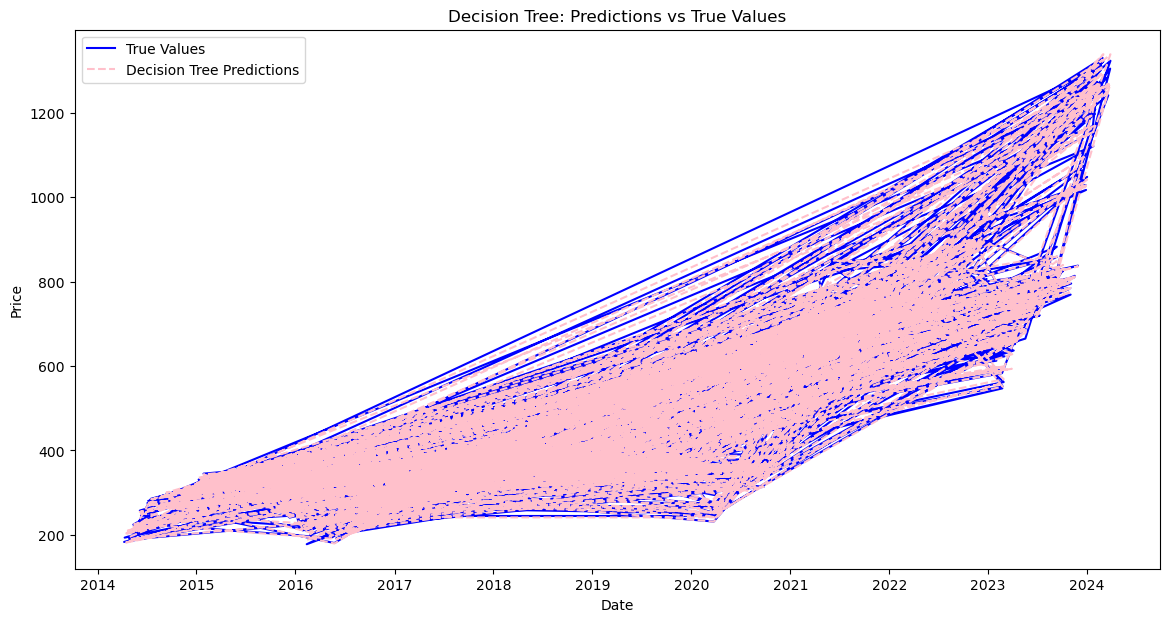

In [143]:
# Plot Decision Tree predictions vs True values
plt.figure(figsize=(14, 7))
plt.plot(test_data['Date'].values, scaler.inverse_transform(test_scaled)[:, 0], label='True Values', color='blue', linestyle='-')
plt.plot(test_data['Date'].values, y_pred_dt_rescaled, label='Decision Tree Predictions', color='pink', linestyle='--')
plt.title('Decision Tree: Predictions vs True Values')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

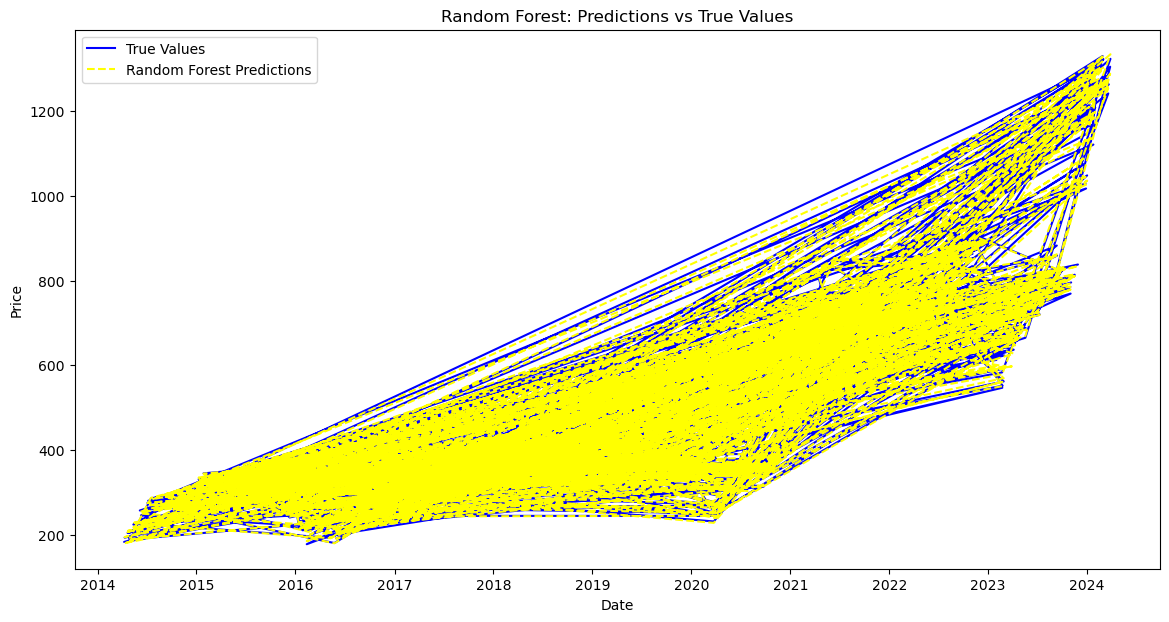

In [145]:
# Plot Random Forest predictions vs True values
plt.figure(figsize=(14, 7))
plt.plot(test_data['Date'].values, scaler.inverse_transform(test_scaled)[:, 0], label='True Values', color='blue', linestyle='-')
plt.plot(test_data['Date'].values, y_pred_rf_rescaled, label='Random Forest Predictions', color='yellow', linestyle='--')
plt.title('Random Forest: Predictions vs True Values')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [157]:
pip install tensorflow

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.11.0-cp311-cp311-win_amd64.whl.metadata (2.5 kB)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached ml_dtypes-0.4.0-cp311-cp311-win_amd64.whl.metadata (20 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.65.1-cp311-cp311-win_amd64.whl.metadata (3.4 kB)
  Using cached keras-3.4.1-py3-none-any.whl.metadata (5.8 kB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp311-cp311-win_amd64.whl.metadata (14 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using

In [159]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

In [227]:
# Prepare the data
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0]  # Only predict the 'Price'
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [229]:
# Parameters
seq_length = 10
batch_size = 32
epochs = 20

In [231]:
# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']])

# Create sequences
X, y = create_sequences(data_scaled, seq_length)

In [233]:
# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [235]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [237]:
# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, shuffle=False)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0041 - val_loss: 0.0230
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0109 - val_loss: 0.0075
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.0139e-04 - val_loss: 0.0034
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.9373e-04 - val_loss: 0.0015
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - val_loss: 8.0840e-04
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.1760e-04 - val_loss: 5.6535e-04
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0014 - val_loss: 5.7478e-04
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.1276e-04 - val_loss: 4.5347e-04
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.1769e-04 - val_loss: 6.4754e-04
Epoch 12/20
56/56 ━━━━

In [239]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [245]:
# Rescale predictions
def rescale_predictions(preds, original, scaler):
    preds_padded = np.pad(preds, ((0, 0), (0, original.shape[1])), 'constant', constant_values=0)
    preds_rescaled = scaler.inverse_transform(preds_padded)[:, 0]
    return preds_rescaled

In [247]:
X_train_last = X_train[:, -1, 1:]
X_test_last = X_test[:, -1, 1:]

In [249]:
y_pred_train_rescaled = rescale_predictions(y_pred_train, X_train_last, scaler)
y_pred_test_rescaled = rescale_predictions(y_pred_test, X_test_last, scaler)
y_train_rescaled = rescale_predictions(y_train.reshape(-1, 1), X_train_last, scaler)
y_test_rescaled = rescale_predictions(y_test.reshape(-1, 1), X_test_last, scaler)

In [251]:
# Check shapes to debug
print(f"y_pred_train_rescaled shape: {y_pred_train_rescaled.shape}")
print(f"y_pred_test_rescaled shape: {y_pred_test_rescaled.shape}")
print(f"y_train_rescaled shape: {y_train_rescaled.shape}")
print(f"y_test_rescaled shape: {y_test_rescaled.shape}")

y_pred_train_rescaled shape: (1968,)
y_pred_test_rescaled shape: (492,)
y_train_rescaled shape: (1968,)
y_test_rescaled shape: (492,)


In [253]:
# Evaluate the model
print("LSTM Model")
print("Train MAPE:", mean_absolute_percentage_error(y_train_rescaled, y_pred_train_rescaled))
print("Test MAPE:", mean_absolute_percentage_error(y_test_rescaled, y_pred_test_rescaled))
print("Train R-squared:", r2_score(y_train_rescaled, y_pred_train_rescaled))
print("Test R-squared:", r2_score(y_test_rescaled, y_pred_test_rescaled))

LSTM Model
Train MAPE: 0.06397653547562103
Test MAPE: 0.03311616038466465
Train R-squared: 0.9749266291108685
Test R-squared: 0.9439539670186743


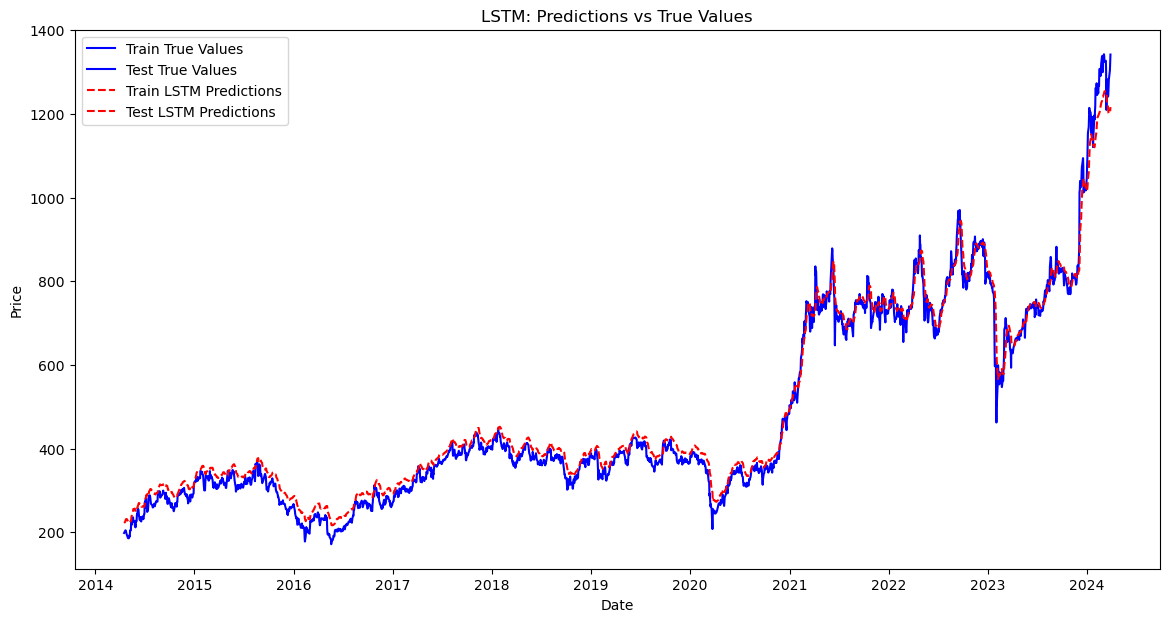

In [255]:
# Plot LSTM predictions vs True values for the test set
plt.figure(figsize=(14, 7))
plt.plot(data['Date'].values[seq_length:split+seq_length], y_train_rescaled, label='Train True Values', color='blue', linestyle='-')
plt.plot(data['Date'].values[split+seq_length:], y_test_rescaled, label='Test True Values', color='blue', linestyle='-')
plt.plot(data['Date'].values[seq_length:split+seq_length], y_pred_train_rescaled, label='Train LSTM Predictions', color='red', linestyle='--')
plt.plot(data['Date'].values[split+seq_length:], y_pred_test_rescaled, label='Test LSTM Predictions', color='red', linestyle='--')
plt.title('LSTM: Predictions vs True Values')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()